In [1]:
!python ../src/utils.py
%reload_ext autoreload

In [2]:
import os
import math
import ROOT as rt
import numpy as np
import matplotlib.pyplot as plt
import utils 
from ROOT import VecOps
from analysis import (df, df_filtered, tree, HMNCSBR, TRUNCSBR, COLOR_MAP)

name_tag = str(utils.TAG)
print("cwd:", os.getcwd())

cwd: /home/student/projects/optimizing_DEDx_estimator/notebooks


In [3]:
cluster = df.AsNumpy(["cluster_DeDxStrip"])["cluster_DeDxStrip"]

In [4]:
drawer = utils.HistogramDrawer()


In [5]:

# checking how the TTree arranges the data I need

print(f"number of events:{tree.GetEntries()}\n")

count = 0
for (i, event), (j, tracks) in zip(
      enumerate(tree), 
      enumerate(cluster)
    ):
    if tracks:
        avg = event.DeDx_IhStrip
        for i,track in enumerate(tracks):
            hits = len(track)
            thrshld = 22
            if hits > thrshld:
                print(f"Event ID{event.event} with {len(tracks)} tracks\n Showing only those with hits > {thrshld} : ")
                print(f"\tTrack No.{i+1} with {hits} strip hits: {track}\n Track's Harmonic average = {avg[i]}\n")
        # count += 1
        # if count == 100:
        #     break
    

number of events:7713

Event ID36263 with 1 tracks
 Showing only those with hits > 22 : 
	Track No.1 with 23 strip hits: { 5.26964f, 6.01354f, 5.00183f, 5.30874f, 5.27804f, 6.56701f, 8.34674f, 9.29797f, 7.39553f, 5.33937f, 4.63904f, 5.66134f, 4.69567f, 5.69908f, 9.71308f, 6.32411f, 5.13122f, 5.05548f, 4.80878f, 4.73389f, 5.56630f, 5.81295f, 5.77556f }
 Track's Harmonic average = 5.637402057647705

Event ID42880 with 4 tracks
 Showing only those with hits > 22 : 
	Track No.2 with 26 strip hits: { 9.14398f, 5.98114f, 5.79338f, 6.73284f, 5.57405f, 6.92061f, 9.92679f, 5.16695f, 11.8683f, 8.29845f, 9.01876f, 8.73690f, 6.38828f, 6.02906f, 6.10583f, 6.43450f, 6.04795f, 6.16403f, 5.70021f, 5.89341f, 6.37663f, 6.00926f, 6.29966f, 5.56496f, 6.06761f, 5.17837f }
 Track's Harmonic average = 6.424683570861816

Event ID63017 with 2 tracks
 Showing only those with hits > 22 : 
	Track No.2 with 23 strip hits: { 3.61078f, 3.36644f, 3.52082f, 5.92984f, 3.27378f, 4.72533f, 7.56682f, 3.10628f, 3.27776f, 4

In [6]:
# Event ID42880 with 4 tracks
#  Showing only those with hits > 25 : 
# 	Track No.2 with 26 strip hits: { 9.14398f, 5.98114f, 5.79338f, 6.73284f, 5.57405f, 6.92061f, 9.92679f, 5.16695f, 11.8683f, 8.29845f, 9.01876f, 8.73690f, 6.38828f, 6.02906f, 6.10583f, 6.43450f, 6.04795f, 6.16403f, 5.70021f, 5.89341f, 6.37663f, 6.00926f, 6.29966f, 5.56496f, 6.06761f, 5.17837f }
#  Track's Harmonic average = 6.424683570861816

# Event ID36263 with 1 tracks
#  Showing only those with hits > 22 : 
# 	Track No.1 with 23 strip hits: { 5.26964f, 6.01354f, 5.00183f, 5.30874f, 5.27804f, 6.56701f, 8.34674f, 9.29797f, 7.39553f, 5.33937f, 4.63904f, 5.66134f, 4.69567f, 5.69908f, 9.71308f, 6.32411f, 5.13122f, 5.05548f, 4.80878f, 4.73389f, 5.56630f, 5.81295f, 5.77556f }
#  Track's Harmonic average = 5.637402057647705

# Event ID42880 with 4 tracks
#  Showing only those with hits > 22 : 
# 	Track No.2 with 26 strip hits: { 9.14398f, 5.98114f, 5.79338f, 6.73284f, 5.57405f, 6.92061f, 9.92679f, 5.16695f, 11.8683f, 8.29845f, 9.01876f, 8.73690f, 6.38828f, 6.02906f, 6.10583f, 6.43450f, 6.04795f, 6.16403f, 5.70021f, 5.89341f, 6.37663f, 6.00926f, 6.29966f, 5.56496f, 6.06761f, 5.17837f }
#  Track's Harmonic average = 6.424683570861816

# Event ID63017 with 2 tracks
#  Showing only those with hits > 22 : 
# 	Track No.2 with 23 strip hits: { 3.61078f, 3.36644f, 3.52082f, 5.92984f, 3.27378f, 4.72533f, 7.56682f, 3.10628f, 3.27776f, 4.76402f, 3.20155f, 2.85852f, 2.93486f, 2.85863f, 2.59176f, 2.85845f, 4.40225f, 8.93740f, 10.7485f, 2.36296f, 3.48760f, 2.61089f, 4.44009f }
#  Track's Harmonic average = 3.4507217407226562

# Event ID73523 with 2 tracks
#  Showing only those with hits > 22 : 
# 	Track No.1 with 23 strip hits: { 11.5992f, 9.66067f, 10.0737f, 9.91495f, 9.91482f, 9.15228f, 8.07172f, 11.0589f, 9.50191f, 10.5506f, 9.59708f, 8.61192f, 8.45315f, 9.78804f, 7.00023f, 6.72602f, 6.82396f, 6.41209f, 6.15704f, 7.68714f, 6.21618f, 6.47145f, 6.00068f }
#  Track's Harmonic average = 7.973351001739502

In [7]:
target_event = 36263      # the event you asked for
target_hits  = 23         # track must have exactly 23 strip hits
t = []
# --- loop once over the tree ------------------------------------------------
for evt in tree:                       # evt is the TTree reader object
    if evt.event != target_event:      # adjust branch name if not 'event'
        continue

    # evt.cluster_DeDxStrip is a vector<vector<float>>
    for idx, track in enumerate(evt.cluster_DeDxStrip):
        if len(track) == target_hits:
            t = track
            print(f"Event {target_event}  Track {idx+1}  "
                  f"{len(track)} hits\n{list(track)}")
            break     # found it, exit inner loop
    break             # event found, exit outer loop

print(t)

Event 36263  Track 1  23 hits
[5.269637584686279, 6.013542652130127, 5.001830577850342, 5.308736801147461, 5.278040409088135, 6.567014694213867, 8.346741676330566, 9.297966003417969, 7.395531177520752, 5.339369297027588, 4.639042854309082, 5.661344051361084, 4.695667266845703, 5.699080944061279, 9.713075637817383, 6.324105262756348, 5.131218433380127, 5.055481910705566, 4.808780193328857, 4.73388671875, 5.566300392150879, 5.812950611114502, 5.775557041168213]
{ 5.26964f, 6.01354f, 5.00183f, 5.30874f, 5.27804f, 6.56701f, 8.34674f, 9.29797f, 7.39553f, 5.33937f, 4.63904f, 5.66134f, 4.69567f, 5.69908f, 9.71308f, 6.32411f, 5.13122f, 5.05548f, 4.80878f, 4.73389f, 5.56630f, 5.81295f, 5.77556f }


****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      1.49557
NDf                       =            3
Edm                       =  7.71462e-06
NCalls                    =          211
Constant                  =       117.53   +/-   114.468     
MPV                       =      5.00131   +/-   0.230343    
Sigma                     =     0.238048   +/-   0.148611     	 (limited)


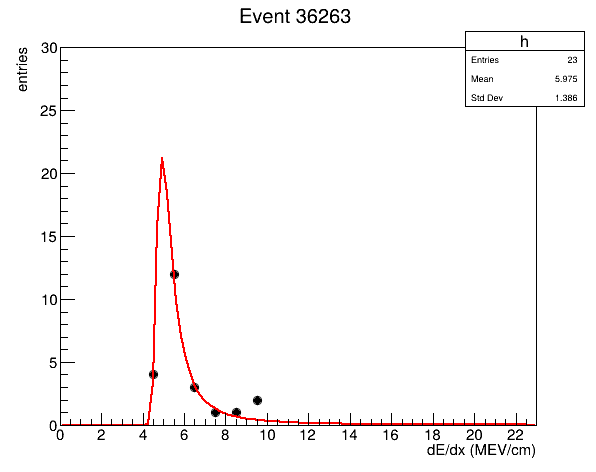

In [8]:
# track now holds the list / RVec<float> of 23 strip charges
charges = list(t)          

# 1) pick sensible histogram limits -----------------------------
qmin, qmax = min(charges), max(charges)
lo  = 0.8 * qmin              
hi  = 1.1 * qmax               
nbins = 23                     

# 2) fill the histogram -----------------------------------------
h = rt.TH1F("h", f"Event {target_event};dE/dx (MEV/cm);entries", nbins, 0, nbins)
for q in charges:
    h.Fill(q)

# 3) draw (and optionally fit) ----------------------------------
c = rt.TCanvas("c", "", 600, 500)
h.Draw("P")
h.SetMarkerStyle(20)
h.SetMaximum(30)

# optional Landau fit:
h.Fit("landau")              # remove 'Q' if you want the fit print-out
c.Draw()



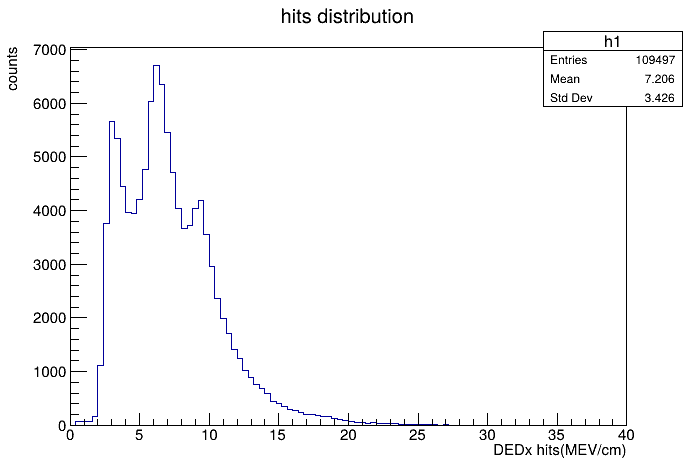

In [9]:
h1 = rt.TH1F("h1", " hits distribution; DEDx hits(MEV/cm); counts", 100, 0, 40)

for tracks in cluster:
  for track in tracks:  
    for hit in track:
      h1.Fill(hit)

c = rt.TCanvas()
h1.Draw()
c.Draw()

In [10]:
# drawer.save(c, f"{utils.PLOTS_DIR}/Hits distribution",["png"])

26
{ 9.14398f, 5.98114f, 5.79338f, 6.73284f, 5.57405f, 6.92061f, 9.92679f, 5.16695f, 11.8683f, 8.29845f, 9.01876f, 8.73690f, 6.38828f, 6.02906f, 6.10583f, 6.43450f, 6.04795f, 6.16403f, 5.70021f, 5.89341f, 6.37663f, 6.00926f, 6.29966f, 5.56496f, 6.06761f, 5.17837f }
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      1.12899
NDf                       =            2
Edm                       =  8.61083e-06
NCalls                    =          127
Constant                  =      75.8701   +/-   29.6074     
MPV                       =      6.15598   +/-   0.188816    
Sigma                     =     0.451747   +/-   0.181885     	 (limited)


Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).


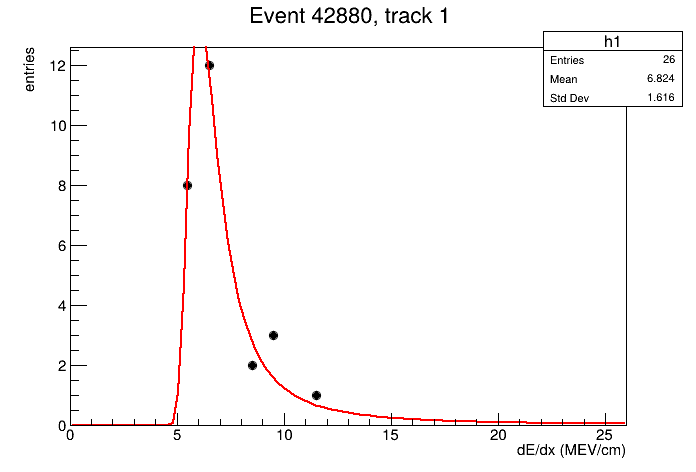

In [11]:

thrshld = 23

for event, (j, tracks) in zip(
      tree, 
      enumerate(cluster)
    ):
  hists = []
  for i, track in enumerate(tracks): 
    if len(track) > thrshld:
      hist = rt.TH1F(f"h{i}", f"Event {event.event}, track {i};dE/dx (MEV/cm);entries", len(track), 0, len(track))
      c = rt.TCanvas()
      print(len(track))
    
      for hit in track:
          hist.Fill(hit)
      hist.Draw("P")
      hist.SetMarkerStyle(20)
      hist.Fit("landau")
      c.Draw("same")
      print(track)
    #print(track)
    
    
    #TODO: FIT PARAMETERS AND HARMONIC FOR EACH TRACK IN A TUPLE AND SAVE THAT INTO AN ARRAY, draw a 2d corelation histogram btween the two tuples
    #TODO: for about 10 fits, save images, and 

In [12]:
# drawer.save(c, f"{utils.PLOTS_DIR}/event42880, track 1 ratio plot",["png"])

In [13]:
def fit_range(lst: list, offset):
  start = min(lst) - offset
  end = max(lst) + offset
  return (start, end)
  

In [14]:
# #TIGHTENED THE FIT RANGE

# thrshld = 10
# max_hists = 20
# hist_count = 0
# # leg = rt.TLegend(0.65,0.52,0.88,0.7)

# hists = {} #dictionary to store histograms
# harmonic2_means = []
# for event, tracks in zip(tree, cluster):
# #  hists = []
#     for trk_idx, track in enumerate(tracks): 
#       if len(track) > thrshld:
#         if hist_count >= max_hists:
#           break
#         #computing harmonic2
#         harmonic2 = math.sqrt( len(track) / sum( (1.0 / (x*x)) for x in track if x > 0 ) )  #turn this into a function later on
#         harmonic2_means.append(harmonic2)
#         hist_name = f"fit{hist_count}"
#         title     = f"Ev {event.event}, Trk {trk_idx};dE/dx (MeV/cm);Entries"
#         hist = rt.TH1F(hist_name, title, len(track), 0, len(track))
#         #c = rt.TCanvas()
#         # print(len(track))
      
#         for hit in track:
#             hist.Fill(hit)
#         hist.Draw("P")
#         hist.SetMarkerStyle(20)
#         xmin, xmax = fit_range(track, 1)
#         hist.Fit("landau", "RQ", "", xmin, xmax)
#         #c.Draw("same")
#         #print(track)
        
#         hists[hist_name] = hist # stores histograms in dict with unique key
        
#         hist_count += 1
        
#     if hist_count >= max_hists:
#         break  
  
# print("Stored histograms:", list(hists.keys()))
# print(harmonic2_means)

In [28]:
#TIGHTENED THE FIT RANGE AND INTRODUCED SEEDING

thrshld = 10
max_hists = 20
hist_count = 0
# leg = rt.TLegend(0.65,0.52,0.88,0.7)

hists = {} #dictionary to store histograms
harmonic2_means = []
for event, tracks in zip(tree, cluster):
#  hists = []
    for trk_idx, track in enumerate(tracks): 
      if len(track) > thrshld:
        if hist_count >= max_hists:
          break
        #computing harmonic2
        harmonic2 = math.sqrt( len(track) / sum( (1.0 / (x*x)) for x in track if x > 0 ) )  #turn this into a function later on
        
        harmonic2_means.append(harmonic2)
        
        bin = int(len(track)/2.0)
        hist_name = f"fit{hist_count}"
        title     = f"Ev {event.event}, Trk {trk_idx};dE/dx (MeV/cm);Entries"
        hist = rt.TH1F(hist_name, title, bin, 0, len(track))
        
        bin_width = str(hist.GetBinWidth(bin))
        
        hist.GetYaxis().SetTitle("Entries "+ bin_width)
        
        
        
        
        
        
        
        
        
        # hist = rt.TH1F(hist_name, title, bin, 0, len(track))
        # bin_width = hist.GetBinWidth()
        #c = rt.TCanvas()
        # print(len(track))
      
        for hit in track:
            hist.Fill(hit)
        hist.Draw("P")
        hist.SetMarkerStyle(20)
        
        #trying to derive sensible seeds from each histogram
        amp_guess  = hist.GetMaximum()                       # scale
        mpv_guess  = hist.GetBinCenter(hist.GetMaximumBin()) # MPV
        sigma_guess = 0.3 * hist.GetRMS() or 0.1*mpv_guess   # crude width
        
        
        xmin, xmax = fit_range(track, 1)
        f_landau = rt.TF1("f_landau", "landau", xmin, xmax)
        f_landau.SetParameters(amp_guess, mpv_guess, sigma_guess)   # seeds
        
        # I'm trying to keep Minuit away from crazy regions
        f_landau.SetParLimits(1, xmin, xmax)         # MPV must stay inside data
        f_landau.SetParLimits(2, 0.05, xmax - xmin)  # σ positive, < full range
        
        hist.Fit(f_landau, "RQ")
        #c.Draw("same")
        #print(track)
        
        hists[hist_name] = hist # stores histograms in dict with unique key
        
        hist_count += 1
        
    if hist_count >= max_hists:
        break  
  
print("Stored histograms:", list(hists.keys()), list(hists.values()))
print(harmonic2_means)

Stored histograms: ['fit0', 'fit1', 'fit2', 'fit3', 'fit4', 'fit5', 'fit6', 'fit7', 'fit8', 'fit9', 'fit10', 'fit11', 'fit12', 'fit13', 'fit14', 'fit15', 'fit16', 'fit17', 'fit18', 'fit19'] [<cppyy.gbl.TH1F object at 0x5ed3cd4b9d90>, <cppyy.gbl.TH1F object at 0x5ed3cd4c0d00>, <cppyy.gbl.TH1F object at 0x5ed3cd4bf460>, <cppyy.gbl.TH1F object at 0x5ed3cd4bdbd0>, <cppyy.gbl.TH1F object at 0x5ed3cd4c7230>, <cppyy.gbl.TH1F object at 0x5ed3cd4c97a0>, <cppyy.gbl.TH1F object at 0x5ed3cd4cf6a0>, <cppyy.gbl.TH1F object at 0x5ed3cd4e6f70>, <cppyy.gbl.TH1F object at 0x5ed3cd4e56e0>, <cppyy.gbl.TH1F object at 0x5ed3cd4e2040>, <cppyy.gbl.TH1F object at 0x5ed3cd4d3640>, <cppyy.gbl.TH1F object at 0x5ed3cd4e0f00>, <cppyy.gbl.TH1F object at 0x5ed3cd4f7000>, <cppyy.gbl.TH1F object at 0x5ed3cd4f5820>, <cppyy.gbl.TH1F object at 0x5ed3cd4de640>, <cppyy.gbl.TH1F object at 0x5ed3cd4dee40>, <cppyy.gbl.TH1F object at 0x5ed3cd501af0>, <cppyy.gbl.TH1F object at 0x5ed3cd500ac0>, <cppyy.gbl.TH1F object at 0x5ed3cd4

Warning in <TFile::Append>: Replacing existing TH1: fit0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit3 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit4 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit5 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit6 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit7 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit8 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit9 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit10 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: fit11 (Potential memory leak).
Warning in <TF

In [29]:
c = rt.TCanvas()
stack = utils.write_stacked_histos("fits", hists, "some tracks fitted with the landau", c)

Error in <TFile::WriteTObject>: Directory ../data/HSCPgluino_M-1800_fromAOD.root is not writable
Error in <TFile::WriteTObject>: Directory ../data/HSCPgluino_M-1800_fromAOD.root is not writable


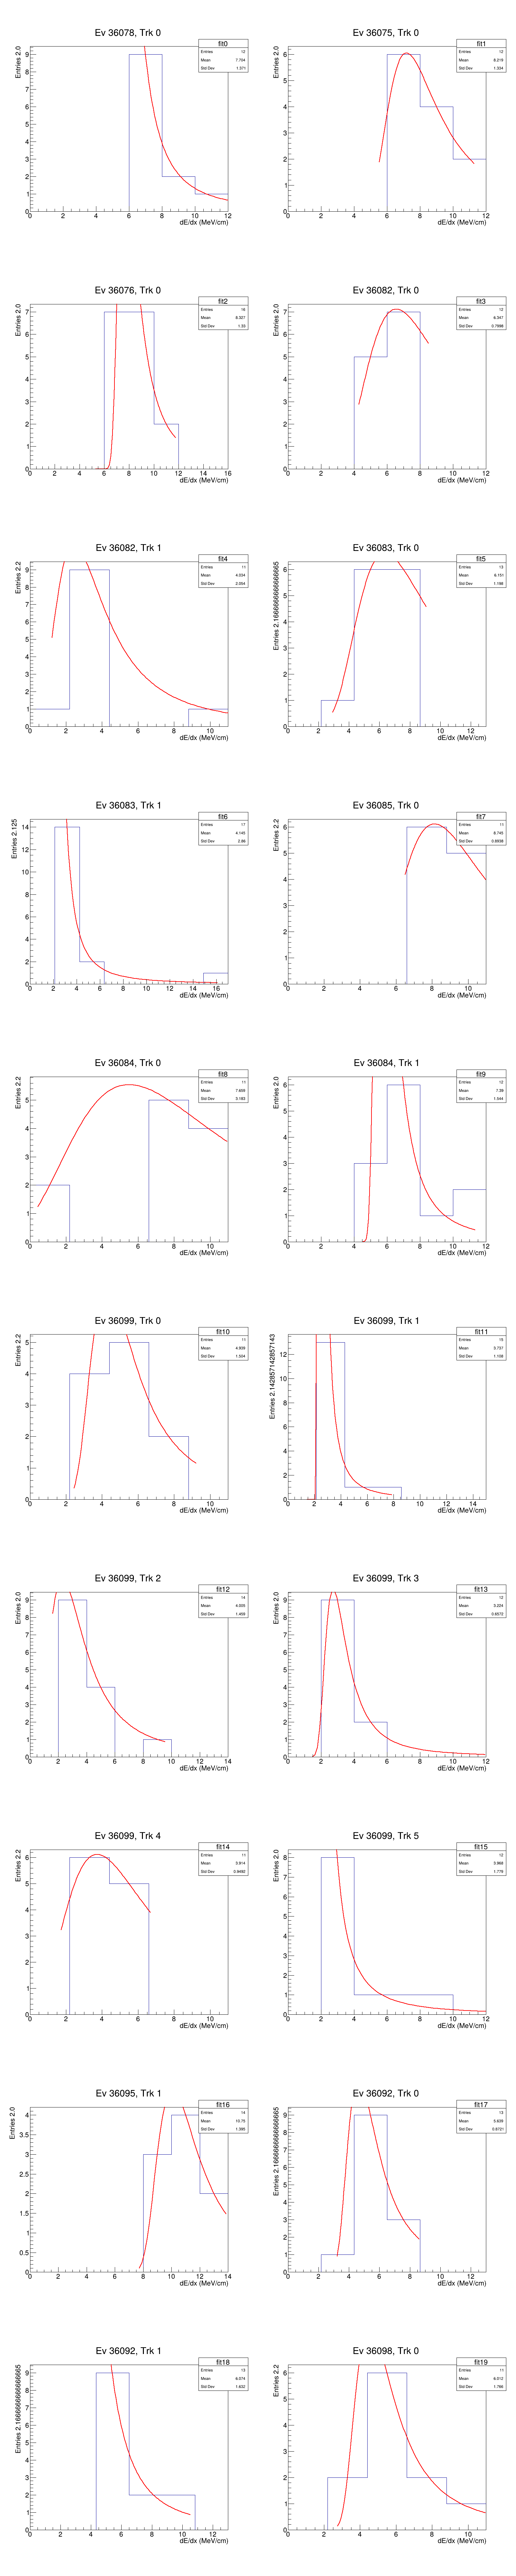

In [30]:
fit_list = stack.GetHists()
N = fit_list.GetSize()

cols = 2
rows = math.ceil(N/cols)

c = rt.TCanvas("c_all", "All fits", cols*800, rows*800)
c.Divide(cols, rows)

for i in range(N):
  pad = c.cd(i+1)
  fit = fit_list.At(i)
  fit.Draw()

c.Modified()
c.Draw()

In [31]:
#TODO: find the min and max of each track's distribution, use that to force the fit's start and end, then see how the distribution looks 

In [32]:
# drawer.save(c, f"{utils.PLOTS_DIR}/some ratio plots tightened and seeded, bigger bin",["png"])

In [33]:
corel_params = []      # (mpv, h2_mean)
parameters   = []      # (mpv, sigma)

for (hist_name, hist), h2_mean in zip(hists.items(), harmonic2_means):

    f = hist.GetFunction("landau")
    if not f:                          # fit might have failed
        print(f"[skip] {hist_name}: no Landau function attached")
        continue

    mpv   = f.GetParameter(1)
    sigma = f.GetParameter(2)

    corel_params.append((mpv, h2_mean))
    parameters.append((mpv, sigma))

print(" (mpv, sigma):", parameters)
print(" (mpv, h2) :", corel_params)


[skip] fit0: no Landau function attached
[skip] fit1: no Landau function attached
[skip] fit2: no Landau function attached
[skip] fit3: no Landau function attached
[skip] fit4: no Landau function attached
[skip] fit5: no Landau function attached
[skip] fit6: no Landau function attached
[skip] fit7: no Landau function attached
[skip] fit8: no Landau function attached
[skip] fit9: no Landau function attached
[skip] fit10: no Landau function attached
[skip] fit11: no Landau function attached
[skip] fit12: no Landau function attached
[skip] fit13: no Landau function attached
[skip] fit14: no Landau function attached
[skip] fit15: no Landau function attached
[skip] fit16: no Landau function attached
[skip] fit17: no Landau function attached
[skip] fit18: no Landau function attached
[skip] fit19: no Landau function attached
 (mpv, sigma): []
 (mpv, h2) : []


In [ ]:
len(fit_list)

20

In [34]:
#FIT PARAMETERS, MPV AND SIGMA

fit_result = fit_list[1].GetFunction("landau")
corel_params = []
parameters = []

for fit, h2_mean in zip(fit_list, harmonic2_means):
  fit_result = fit.GetFunction("landau")
  mpv = fit_result.GetParameter(1)  # Most probable value
  sigma = fit_result.GetParameter(2) # stdev
  corel_params.append((mpv, h2_mean))
  parameters.append((mpv, sigma))

print("(mpv: stdev):          ", parameters)
print("(mpv: harmonic2 mean): ", corel_params)



TypeError: none of the 2 overloaded methods succeeded. Full details:
  attempt to access a null-pointer
  double TF1::GetParameter(const TString& name) =>
    TypeError: could not convert argument 1

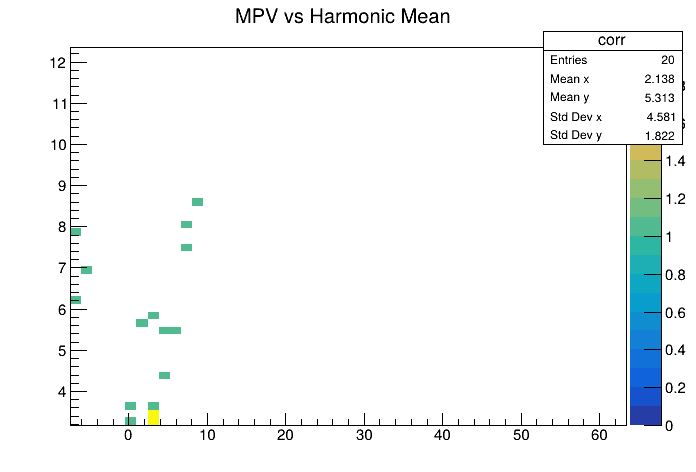

In [ ]:
c = rt.TCanvas()

x_vals = [r[0] for r in corel_params]
y_vals = [r[1] for r in corel_params]
corr_hist = rt.TH2F("corr", "MPV vs Harmonic Mean", 50, min(x_vals), max(x_vals), 50, min(y_vals), max(y_vals))
for x, y in corel_params:
    corr_hist.Fill(x, y)
corr_hist.Draw("COLZ")

c.Draw()


In [ ]:
# import ROOT as rt
# import math, numpy as np

# thrshld    = 10          # min strip hits per track
# max_hists  = 5000        # safety cap (optional)

# mpv_h2_pairs = []        # final flat list of (MPV, harmonic-2)

# hist_count   = 0
# hists_good   = {}        # keep only successfully-fitted histos

# for event, tracks in zip(tree, cluster):               # cluster parallels tree
#     for trk_idx, track in enumerate(tracks):

#         if len(track) <= thrshld:
#             continue

#         # ---------- build & fill histogram
#         hist_name = f"trkFit{hist_count}"
#         hist      = rt.TH1F(hist_name, "dE/dx per strip", len(track), 0, len(track))
#         for hit in track:
#             hist.Fill(hit)

#         if hist.GetEntries() < 6:          # too little data ⇒ skip
#             continue

#         # ---------- Landau fit
#         fit_ptr = hist.Fit("landau", "QS0")      # Q=quiet, S=return result, 0=no-draw
#         if not fit_ptr or fit_ptr.Status() != 0: # fit did not converge → skip
#             hist_count += 1
#             continue

#         # ---------- extract MPV from the fit
#         landau_f = hist.GetFunction("landau")
#         mpv      = landau_f.GetParameter(1)      # Most-probable value

#         # ---------- compute harmonic-2 ( Ih )
#         h2 = math.sqrt(len(track) /
#                        sum((1.0 / (x*x)) for x in track if x > 0))

#         # ---------- store results
#         mpv_h2_pairs.append((mpv, h2))
#         hists_good[hist_name] = hist
#         hist_count += 1

#         if hist_count >= max_hists:
#             break
#     if hist_count >= max_hists:
#         break

# # ------------- flat NumPy array if you like
# mpv_h2_np = np.array(mpv_h2_pairs, dtype=np.float64)   # shape (N, 2)

# print(f"Kept {len(mpv_h2_pairs)} fitted tracks out of {hist_count} candidates")
# print("First five (MPV, harmonic-2) pairs:\n", mpv_h2_pairs[:5])
